In [ ]:
import os, random, shutil


def make_dir(source, target):
    dir_names = os.listdir(source)
    for names in dir_names:
        for i in ['train', 'valid']:
            path = target + '/' + i + '/' + names
            if not os.path.exists(path):
                os.makedirs(path)


def divideTrainValiTest(source, target):

    pic_name = os.listdir(source)
    
    for classes in pic_name:

        pic_classes_name = os.listdir(os.path.join(source, classes))
        random.shuffle(pic_classes_name)
        

        train_list = pic_classes_name[0:int(0.8 * len(pic_classes_name))]
        valid_list = pic_classes_name[int(0.8 * len(pic_classes_name)):]
        
        for train_pic in train_list:
            shutil.copyfile(source + '/' + classes + '/' + train_pic, target + '/train/' + classes + '/' + train_pic)
        for validation_pic in valid_list:
            shutil.copyfile(source + '/' + classes + '/' + validation_pic,
                            target + '/valid/' + classes + '/' + validation_pic)


if __name__ == '__main__':
    filepath = r'C:/Users/15189/Desktop/DataAnalysis/NASA/data'
    dist = r'C:/Users/15189/Desktop/DataAnalysis/NASA/datanew'
    make_dir(filepath, dist)
    divideTrainValiTest(filepath, dist)

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = 'C:/Users/15189/Desktop/DataAnalysis/NASA/datanew'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 6

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

l

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

## The first Model- Alexnet
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9
----------
train Loss: 1.4858 Acc: 0.7107
valid Loss: 1.2615 Acc: 0.7174

Epoch 1/9
----------
train Loss: 1.4208 Acc: 0.7176
valid Loss: 1.4960 Acc: 0.7174

Epoch 2/9
----------
train Loss: 1.4494 Acc: 0.7299
valid Loss: 2.0839 Acc: 0.7606

Epoch 3/9
----------
train Loss: 1.5153 Acc: 0.7310
valid Loss: 0.8463 Acc: 0.7472

Epoch 4/9
----------
train Loss: 1.5551 Acc: 0.7256
valid Loss: 1.2359 Acc: 0.7785

Epoch 5/9
----------
train Loss: 1.5190 Acc: 0.7293
valid Loss: 0.9394 Acc: 0.7808

Epoch 6/9
----------
train Loss: 1.5648 Acc: 0.7348
valid Loss: 1.5738 Acc: 0.7547

Epoch 7/9
----------
train Loss: 1.5539 Acc: 0.7251
valid Loss: 1.1099 Acc: 0.7666

Epoch 8/9
----------
train Loss: 1.4448 Acc: 0.7357
valid Loss: 1.2047 Acc: 0.7629

Epoch 9/9
----------
train Loss: 1.4315 Acc: 0.7370
valid Loss: 1.1536 Acc: 0.7487

Training complete in 61m 41s
Best val Acc: 0.780761


Epoch 0/9
----------
train Loss: 0.6104 Acc: 0.6738
valid Loss: 0.5799 Acc: 0.6741

Epoch 1/9
----------
train Loss: 0.5912 Acc: 0.6741
valid Loss: 0.5672 Acc: 0.6741

Epoch 2/9
----------
train Loss: 0.5746 Acc: 0.6976
valid Loss: 0.5442 Acc: 0.7151

Epoch 3/9
----------
train Loss: 0.5621 Acc: 0.7155
valid Loss: 0.5524 Acc: 0.7099

Epoch 4/9
----------
train Loss: 0.5519 Acc: 0.7230
valid Loss: 0.5383 Acc: 0.7241

Epoch 5/9
----------
train Loss: 0.5429 Acc: 0.7292
valid Loss: 0.5218 Acc: 0.7405

Epoch 6/9
----------
train Loss: 0.5444 Acc: 0.7237
valid Loss: 0.6062 Acc: 0.6756

Epoch 7/9
----------
train Loss: 0.5420 Acc: 0.7290
valid Loss: 0.5333 Acc: 0.7047

Epoch 8/9
----------
train Loss: 0.5322 Acc: 0.7321
valid Loss: 0.5178 Acc: 0.7427

Epoch 9/9
----------
train Loss: 0.5319 Acc: 0.7379
valid Loss: 0.5156 Acc: 0.7487

Training complete in 120m 36s
Best val Acc: 0.748695


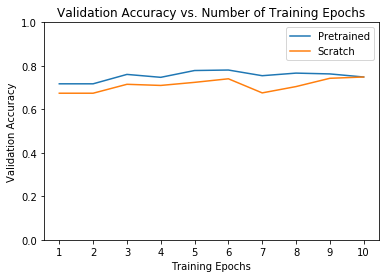

In [9]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [10]:
## The second Model
model_name2 = "resnet"

# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_name2, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\15189/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:03<00:00, 13770216.61it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
# Send the model to GPU
model_ft2 = model_ft2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update2 = model_ft2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update2 = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update2.append(param)
            print("\t",name)
else:
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft2 = optim.SGD(params_to_update2, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [13]:
# Setup the loss fxn
criterion2 = nn.CrossEntropyLoss()

## The first Model- Alexnet
# Train and evaluate
model_ft2, hist2 = train_model(model_ft2, dataloaders_dict, criterion2, optimizer_ft2, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9
----------
train Loss: 0.6129 Acc: 0.7101
valid Loss: 0.5723 Acc: 0.7524

Epoch 1/9
----------
train Loss: 0.5944 Acc: 0.7167
valid Loss: 0.5035 Acc: 0.7778

Epoch 2/9
----------
train Loss: 0.6040 Acc: 0.7181
valid Loss: 0.5215 Acc: 0.7703

Epoch 3/9
----------
train Loss: 0.5912 Acc: 0.7329
valid Loss: 0.8646 Acc: 0.5861

Epoch 4/9
----------
train Loss: 0.5807 Acc: 0.7316
valid Loss: 0.5996 Acc: 0.7479

Epoch 5/9
----------
train Loss: 0.5920 Acc: 0.7329
valid Loss: 0.5082 Acc: 0.7815

Epoch 6/9
----------
train Loss: 0.5991 Acc: 0.7314
valid Loss: 0.5027 Acc: 0.7726

Epoch 7/9
----------
train Loss: 0.6451 Acc: 0.7131
valid Loss: 0.4709 Acc: 0.7942

Epoch 8/9
----------
train Loss: 0.5783 Acc: 0.7318
valid Loss: 0.7670 Acc: 0.6518

Epoch 9/9
----------
train Loss: 0.6057 Acc: 0.7204
valid Loss: 0.9745 Acc: 0.5652

Training complete in 106m 57s
Best val Acc: 0.794183


Epoch 0/9
----------
train Loss: 0.6420 Acc: 0.6609
valid Loss: 0.5350 Acc: 0.7323

Epoch 1/9
----------
train Loss: 0.6163 Acc: 0.6863
valid Loss: 0.8783 Acc: 0.5198

Epoch 2/9
----------
train Loss: 0.6051 Acc: 0.6960
valid Loss: 0.5663 Acc: 0.7427

Epoch 3/9
----------
train Loss: 0.5883 Acc: 0.7088
valid Loss: 0.5999 Acc: 0.7092

Epoch 4/9
----------
train Loss: 0.5657 Acc: 0.7193
valid Loss: 0.5680 Acc: 0.7330

Epoch 5/9
----------
train Loss: 0.5595 Acc: 0.7318
valid Loss: 0.5292 Acc: 0.7345

Epoch 6/9
----------
train Loss: 0.5548 Acc: 0.7355
valid Loss: 0.8783 Acc: 0.6085

Epoch 7/9
----------
train Loss: 0.5429 Acc: 0.7396
valid Loss: 0.5323 Acc: 0.7427

Epoch 8/9
----------
train Loss: 0.5316 Acc: 0.7415
valid Loss: 0.5035 Acc: 0.7532

Epoch 9/9
----------
train Loss: 0.5302 Acc: 0.7430
valid Loss: 0.5109 Acc: 0.7465

Training complete in 259m 28s
Best val Acc: 0.753169


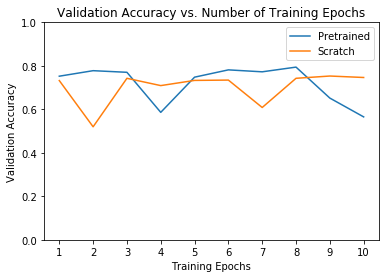

In [15]:
# Initialize the non-pretrained version of the model used for this run
scratch_model2,_ = initialize_model(model_name2, num_classes, feature_extract=False, use_pretrained=False)
scratch_model2 = scratch_model2.to(device)
scratch_optimizer2 = optim.SGD(scratch_model2.parameters(), lr=0.001, momentum=0.9)
scratch_criterion2 = nn.CrossEntropyLoss()
_,scratch_hist2 = train_model(scratch_model2, dataloaders_dict, scratch_criterion2, scratch_optimizer2, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist2]
shist = [h.cpu().numpy() for h in scratch_hist2]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
#referance
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.htm